# Cyclostationary Analysis

Hi, this notebook contains my current explorations into cyclostationary signal analysis. The code below is work in progress, and is likely not fully correct!

I'm using as main references the following paper, available [here](https://cyclostationarity.com/wp-content/uploads/2021/06/Signal-Processing.pdf), and information from Dr. Chad Spooner's blog "*Clyclostationary Signal Processing*", available [here](https://cyclostationary.blog).

> 1991 W. A. Gardner. EXPLOITATION OF SPECTRAL REDUNDANCY IN CYCLOSTATIONARY SIGNALS. IEEE Signal Processing Magazine, Vol. 8, No. 2, pp. 14-36.

Many thanks to Dr Spooner for his help in fixing a bug in this code!

The code begins by importing some Python packages, and defining functions to estimate our cyclostationary densities and coherences.

In [1]:
import numpy as np
rng = np.random.default_rng()

import scipy.signal as ss

import matplotlib.pyplot as plt
plt.close('all')


def calc_xspec_block(x, y, t, alpha=0):
    """
    Calculate cross-spectrum for one block of data over time samples 't',
    optionally including cyclic frequency shift 'alpha'
    """

    u_block = x*np.exp(-1j*np.pi*alpha*t)
    v_block = y*np.exp(+1j*np.pi*alpha*t)

    u_f = np.fft.fft(u_block)
    v_f = np.fft.fft(v_block)

    Suu = (u_f * u_f.conj()).real
    Svv = (v_f * v_f.conj()).real
    Suv = (u_f * v_f.conj())

    return Suu, Svv, Suv


def cyclic_periodogram(x, y, alpha_vec, Ndft, fs):
    """
    Calculates cyclic spectral density and cyclic spectral coherence using
    periodogram (time-smoothing) method
    """

    N_alpha = alpha_vec.shape[0]

    Nt = x.shape[0]
    N_blocks = Nt//Ndft
    
    df = fs/Ndft
    freq = np.linspace(0, fs-df, Ndft)-fs/2

    # Spectral Correlation Density (SCD) function
    Sxx = np.zeros((N_blocks, N_alpha, Ndft))
    Syy = np.zeros((N_blocks, N_alpha, Ndft))
    Sxy = np.zeros((N_blocks, N_alpha, Ndft), dtype='complex')

    for n in range(N_blocks):

        n_start = n*Ndft
        t_block = np.linspace(n_start/fs, (n_start+Ndft)/fs, Ndft)

        x_block = x[n_start : n_start+Ndft]
        y_block = y[n_start : n_start+Ndft]

        # calculate spectra for alpha values in 'alpha_vec'
        for a, alpha in enumerate(alpha_vec):
            Sxx[n, a, :], Syy[n, a, :], Sxy[n, a, :] = calc_xspec_block(x_block, y_block,
                                                                        t_block, alpha)

    Sxx *= 1/(Ndft*fs)
    Syy *= 1/(Ndft*fs)
    Sxy *= 1/(Ndft*fs)

    # apply FFT shift
    Sxx = np.fft.fftshift(Sxx, axes=(-1))
    Syy = np.fft.fftshift(Syy, axes=(-1))
    Sxy = np.fft.fftshift(Sxy, axes=(-1))

    # average over blocks
    Sxx_avg = Sxx.sum(axis=0)/N_blocks
    Syy_avg = Syy.sum(axis=0)/N_blocks
    Sxy_avg = Sxy.sum(axis=0)/N_blocks
    
    corr_coeff = Sxy_avg/np.sqrt(Sxx_avg*Syy_avg)

    # replace entries outside the principal domain in freq-alpha plane by NaNs
    # (i.e. diamond shape given by |f| > (fs-|alpha|)/2 )
    for a, alpha in enumerate(alpha_vec):
        freqs_outside = (np.abs(freq) > (fs - np.abs(alpha))/2)
        Sxy_avg[a, freqs_outside] = np.nan
        corr_coeff[a, freqs_outside] = np.nan
    
    return Sxy_avg, corr_coeff


We now define some functions to generate test signals that exhibit cyclostationarity:

In [2]:

def create_rect_bpsk(T_bits, num_bits, fc, signal_power_dB, noise_power_dB):
    """
    Generate a rectangular-pulse binary phase-shift keyed signal, as described in 
    https://cyclostationary.blog/2015/09/28/creating-a-simple-cs-signal-rectangular-pulse-bpsk/
    """

    N_samples = num_bits*T_bits

    # Create bit sequence - 0s and 1s
    bit_seq = rng.integers(0, 2, num_bits)

    # Create symbol sequence from bit sequence (-1s and +1s)
    sym_seq = 2*bit_seq - 1

    # generate symbol sequence by intercalating each bit with (T_bits-1) zeros
    zero_mat = np.zeros((T_bits-1, num_bits))
    sym_seq = np.concatenate((sym_seq[np.newaxis, :], zero_mat), axis=0)
    sym_seq = np.reshape(sym_seq, (N_samples,), order='F')

    # Create rectangular pulse function
    p_of_t = np.ones((T_bits,))

    # Convolve bit sequence with pulse function to obtain rectangular-pulse
    # BPSK signal
    s_of_t = ss.lfilter(p_of_t, [1], sym_seq)

    # Apply the carrier frequency.
    e_vec = np.exp(1j*2*np.pi*fc*np.arange(N_samples))
    x_of_t = s_of_t * e_vec

    # Add noise.
    n_of_t = rng.normal(0, 1, N_samples) + 1j*rng.normal(0, 1, N_samples)
    noise_power = np.var(n_of_t)
    noise_power_lin = 10**(noise_power_dB/10)
    pow_factor = np.sqrt(noise_power_lin / noise_power)
    n_of_t = n_of_t * pow_factor
    y_of_t = x_of_t + n_of_t

    return y_of_t


def create_lowpassmod_cos(N_samples, A, N_filter, fc_filter, f_cos, fs):
    """
    Generate bandlimited Gaussian noise, modulating a unitary-amplitude cosine
    wave at 'f_cos' Hz.
    
    The Gaussian noise is lowpassed at 'fc_filter' Hz using a Butterworth filter
    of order 'N_filter', and multiplied by a factor 'A'.
    """
    
    # define lowpass Butterworth filter
    butter_sos = ss.butter(N_filter, fc_filter, output='sos', fs=fs)
    
    # create band-limited Gaussian white noise
    xn = rng.normal(loc=0, scale=1, size=N_samples)
    x_lpn = A*ss.sosfilt(butter_sos, xn)

    # generate cosine wave at 'fc' Hz
    t = np.linspace(0, (N_samples-1)/fs, N_samples)
    xc = np.cos(2*np.pi*f_cos*t)

    return xc*x_lpn



The functions above create a rectangular BPSK signal, as instructed by Dr Spooner in his great [blog](https://cyclostationary.blog/2015/09/28/creating-a-simple-cs-signal-rectangular-pulse-bpsk/), or a lowpassed Gaussian noise modulated by a sine wave. The cell below defines the signal parameters and creates either signal - comment/uncomment the desired option at the top of the cell.

In [3]:
# ********************************************************************************
# comment/uncomment desired option

signal = 'bpsk'
# signal = 'lowpassmod_cos'

# ********************************************************************************


# sampling frequency
fs = 1

if signal == 'bpsk':
    # -----------------------------------------------------------------------------
    # rect BPSK signal

    T_bits = 10                 # Number of samples per bit (1/T_bit is the bit rate)
    num_bits = 32768            # Desired number of bits in generated signal
    fc = 0.05                   # Desired carrier frequency (normalized units)
    noise_power_dB = -10.0      # Noise spectral density (average noise power)
    signal_power_dB = 0.0       # Signal power in decibels

    T = (num_bits*T_bits)/fs
    y = create_rect_bpsk(T_bits, num_bits, fc, signal_power_dB, noise_power_dB)
    # -----------------------------------------------------------------------------

elif signal == 'lowpassmod_cos':
    # -----------------------------------------------------------------------------
    # bandlimited Gaussian white noise modulating a cosine wave
    N_samples = 327680

    # lowpassed white noise parameters
    A = 2                       # white noise amplitude
    N_filter = 6                # lowpass filter order (Butterworth)
    fc_filter = 0.05*fs         # lowpass filter cutoff freq
    f_cos = 0.15*fs             # cosine wave frequency
    
    T = N_samples/fs
    y = create_lowpassmod_cos(N_samples, A, N_filter, fc_filter, f_cos, fs)
    # -----------------------------------------------------------------------------



Here we define our variables for frequency-domain analysis - mainly the number of points in our PSD, a vector of frequencies, and estimate our frequency resolution and time-bandwidth product.

In [4]:
# %% frequency analysis variables

# Number of frequencies to use in PSD estimate
N_psd = 128

df = fs/N_psd
freq_vec = np.linspace(0, fs-df, N_psd) - fs/2

freq_res = fs/(N_psd)       # frequency resolution
TB = T*freq_res             # time-bandwidth product

print('Frequency resolution = {:.2f} Hz'.format(freq_res))
print('Time-bandwidth product = {:.2f}'.format(TB))

Frequency resolution = 0.01 Hz
Time-bandwidth product = 2560.00


We now define a vector of cyclic frequencies `alpha_vec` of interest, and perform the actual calculations of the Cyclic Spectral Density (CSD) and Cyclic Coherence:

In [5]:
# run cyclic periodogram over range of alphas

# range of alphas to test
N_alpha = 21
alpha_vec = np.linspace(0., 1., N_alpha)*fs

# cyclic spectral density
Syy = np.zeros((N_alpha, N_psd))

# cyclic coherence
rho_y = np.zeros((N_alpha, N_psd), dtype='complex')

Syy, rho_y = cyclic_periodogram(y, y, alpha_vec, N_psd, fs)

Finally, we plot the results we obtained.

(Note that estimates outside the principal domain in the `f`-`alpha` plane are replaced by NaNs and don't appear in the plots!)

Text(0.5, 0.5, 'Freq/fs')

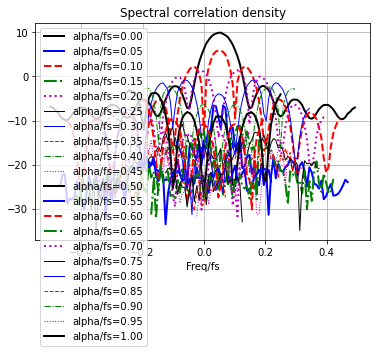

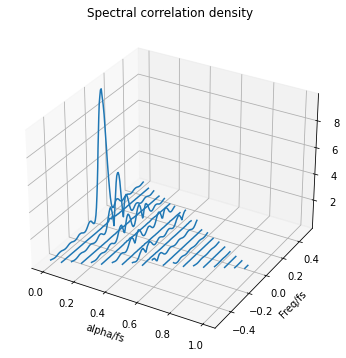

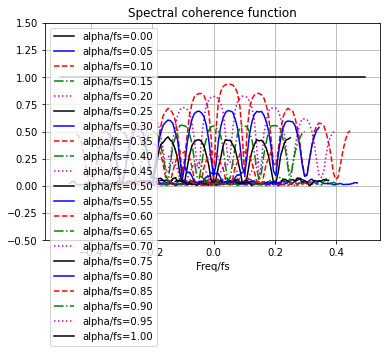

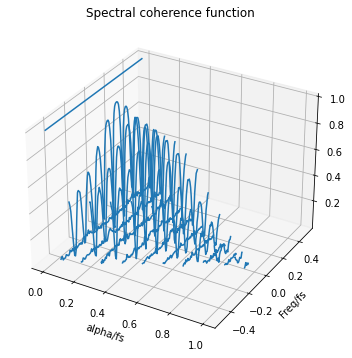

In [6]:
# %% plot spectral correlation density and spectral coherence

# plotting parameters to make plots look pretty
lines = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-']
linewidths = [2.5, 2.5, 2.5, 2.5, 2.5, 1, 1, 1, 1, 1, 1, 0.5]

N_lines = len(lines)

# ********************************************************************************
# plot SCD in dB
plt.figure()
for a in range(N_alpha):
    plt.plot(freq_vec/fs,
             10*np.log10(np.abs(Syy[a, :])),
             linestyle=lines[a%N_lines], color=colors[a%N_lines],
             linewidth=linewidths[a%10],
             label='alpha/fs={:.2f}'.format(alpha_vec[a]/fs))
plt.legend()
plt.xlabel('Freq/fs')
plt.title('Spectral correlation density')
plt.grid()

# plot SCD as wireframe
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection='3d')
ax.plot_wireframe(alpha_vec[:, np.newaxis]/fs, freq_vec/fs,
                  np.abs(Syy),
                  rstride=1, cstride=0)

ax.set_title('Spectral correlation density')
ax.set_xlabel('alpha/fs')
ax.set_ylabel('Freq/fs')

# ********************************************************************************
# plot spectral coherence
plt.figure()
for a in range(N_alpha):
    plt.plot(freq_vec/fs,
             np.abs(rho_y[a, :]),
             linestyle=lines[a%N_lines], color=colors[a%N],
             label='alpha/fs={:.2f}'.format(alpha_vec[a]/fs))
plt.legend()
plt.xlabel('Freq/fs')
plt.title('Spectral coherence function')
plt.grid()
plt.ylim([-0.5, 1.5])

# plot spectral coherence as wireframe
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection='3d')
ax.plot_wireframe(alpha_vec[:, np.newaxis]/fs, freq_vec/fs,
                  np.abs(rho_y),
                  rstride=1, cstride=0)

ax.set_title('Spectral coherence function')
ax.set_xlabel('alpha/fs')
ax.set_ylabel('Freq/fs')
